## Import Libraries

In [1]:
!pip install pymongo

In [2]:
import nltk
import re
import pandas as pd
import numpy as np
import pymongo
import json
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [3]:
connessione = pymongo.MongoClient("mongodb://localhost:27017/")
print(connessione.list_database_names())#si utilizza il db WorldCup
WorldCupDb = connessione["WorldCup"] #crea DB
WorldCupCollection = WorldCupDb["WorldCupTweet"] #crea collezione all'interno del db


['WorldCup', 'admin', 'config', 'local']


In [4]:
selection=WorldCupCollection.find()
dataset=[]
j=0
for i in selection:
    dataset.append(i)

In [5]:
dataset=pd.DataFrame(dataset)

## Pre-processing

In [7]:
dataset.head()

,Unnamed: 0,data_partita,testo,reply_count,like_count,retweet_count,quote_count,hashtags,partita
0,0,2022-11-20,Qatar vs Ecuador was on TVE La 1 / HD. Coverag...,0,0,0,0,"['Qatar', 'Ecuador', 'TVELaHD']",QATAR-ECUADOR
1,1,2022-11-20,Trending Topic: #luigistrangis e #QatarEcuador...,0,0,0,0,"['luigistrangis', 'QatarEcuador']",QATAR-ECUADOR
2,2,2022-11-20,Get my art printed on awesome products. Suppor...,0,0,0,0,"['RBandME', 'findyourthing', 'redbubble', 'USA...",QATAR-ECUADOR
3,3,2022-11-20,World Cup\n\nQatar-Ecuador\n2-0 Ecuador both g...,0,5,0,0,NaN,QATAR-ECUADOR
4,4,2022-11-20,"how the holy heck is this not a goal ,\nand ho...",0,0,0,0,"['var', 'qatar', 'ecuador', 'fraud']",QATAR-ECUADOR


In [8]:
dataset["testo"].head(2)

0    Qatar vs Ecuador was on TVE La 1 / HD. Coverag...
1    Trending Topic: #luigistrangis e #QatarEcuador...
Name: testo, dtype: object

In [9]:
# normalization: testo in minuscolo
dataset["testo"] = dataset["testo"].str.lower()
dataset["testo"].head(2)

0    qatar vs ecuador was on tve la 1 / hd. coverag...
1    trending topic: #luigistrangis e #qatarecuador...
Name: testo, dtype: object

In [10]:
# normalization: rimozione spazi a inizio e fine riga
dataset["testo"] = dataset["testo"].str.strip()
dataset["testo"].head(2)

0    qatar vs ecuador was on tve la 1 / hd. coverag...
1    trending topic: #luigistrangis e #qatarecuador...
Name: testo, dtype: object

In [11]:
# normalization: rimozione caratteri speciali
dataset["testo"] = dataset["testo"].str.replace(r'/', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'?', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'@', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'&', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'-', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'—', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'.', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r',', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'[', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r']', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r':', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r';', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'"', ' ', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r')', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'(', '', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r'  ', ' ', regex=True)
dataset["testo"].head(2)

0    qatar vs ecuador was on tve la 1 hd coverage p...
1    trending topic #luigistrangis e #qatarecuador ...
Name: testo, dtype: object

In [12]:
# normalization: rimozione link
dataset["testo"] = dataset["testo"].str.replace(r'https?\S+|www\.\S+', '', regex=True)
dataset["testo"].head(2)

0    qatar vs ecuador was on tve la 1 hd coverage p...
1       trending topic #luigistrangis e #qatarecuador 
Name: testo, dtype: object

In [13]:
# normalization: good / bad
dataset["testo"] = dataset["testo"].str.replace(r":\)", 'good', regex=True)
dataset["testo"] = dataset["testo"].str.replace(r':\(', 'bad', regex=True)

## Wordcloud

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def most_common_wordcloud(tokens):
    most_common=nltk.FreqDist(tokens).most_common(50)
    most_common_dict = dict(most_common)
  
    wordcloud = WordCloud(height=400, width=1000)
    wordcloud.generate_from_frequencies(frequencies=most_common_dict)
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis("off")

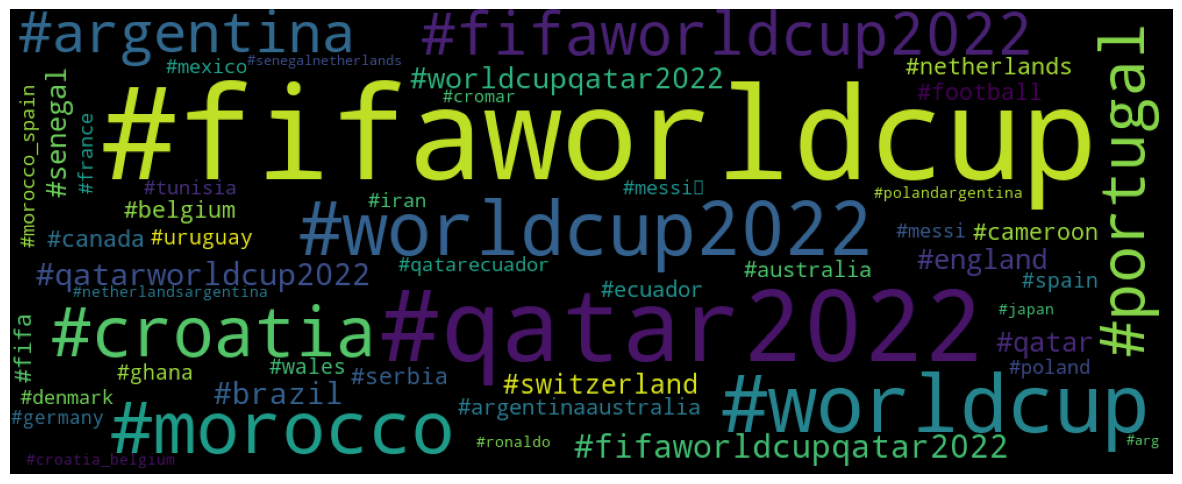

In [15]:
lista_parole = ' '.join([i for i in dataset["testo"]]).split()
most_common_wordcloud([words for words in lista_parole if '#' in words])
plt.show()

In [16]:
# rimozione hashtag dopo la wordcloud (noise sulla sentiment analysis)
dataset["testo"] = dataset["testo"].map(lambda x: re.sub('#', '', x))
dataset["testo"].head(2)

0    qatar vs ecuador was on tve la 1 hd coverage p...
1         trending topic luigistrangis e qatarecuador 
Name: testo, dtype: object

## Stopwords

In [17]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

In [18]:
dataset["testo"] = dataset["testo"].apply(lambda text: remove_stopwords(text))
dataset["testo"].head(2)

0    qatar vs ecuador tve la 1 hd coverage presente...
1          trending topic luigistrangis e qatarecuador
Name: testo, dtype: object

## Tokenization

In [19]:
dataset["tokenized"] = dataset["testo"].str.replace(r' ', ', ')
dataset["tokenized"].head()

0    qatar, vs, ecuador, tve, la, 1, hd, coverage, ...
1      trending, topic, luigistrangis, e, qatarecuador
2    get, art, printed, awesome, products, support,...
3    world, cup, qatarecuador, 20, ecuador, goals, ...
4    holy, heck, goal, second, picture, explainer, ...
Name: tokenized, dtype: object

## Stemming

In [20]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def stemSentence(token_words):
    stem_text=[]
    for word in token_words:
        stem_text.append(porter.stem(word))
    return stem_text

In [21]:
dataset["stemmed"] = stemSentence(dataset["tokenized"])
dataset["stemmed"].head()

0    qatar, vs, ecuador, tve, la, 1, hd, coverage, ...
1      trending, topic, luigistrangis, e, qatarecuador
2    get, art, printed, awesome, products, support,...
3    world, cup, qatarecuador, 20, ecuador, goals, ...
4    holy, heck, goal, second, picture, explainer, ...
Name: stemmed, dtype: object

## Lemming

In [22]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmaSentence(token_words):
    lemma_text=[]
    for word in token_words:
        lemma_text.append(wordnet_lemmatizer.lemmatize(word))
    return lemma_text

In [23]:
dataset["lemmatized"] = stemSentence(dataset["stemmed"])
dataset["lemmatized"].head()

0    qatar, vs, ecuador, tve, la, 1, hd, coverage, ...
1      trending, topic, luigistrangis, e, qatarecuador
2    get, art, printed, awesome, products, support,...
3    world, cup, qatarecuador, 20, ecuador, goals, ...
4    holy, heck, goal, second, picture, explainer, ...
Name: lemmatized, dtype: object

In [24]:
dataset["preprocessed"] = dataset["lemmatized"].str.replace(r',', '', regex=True)

In [25]:
dataset.head()

,Unnamed: 0,data_partita,testo,reply_count,like_count,retweet_count,quote_count,hashtags,partita,tokenized,stemmed,lemmatized,preprocessed
0,0,2022-11-20,qatar vs ecuador tve la 1 hd coverage presente...,0,0,0,0,"['Qatar', 'Ecuador', 'TVELaHD']",QATAR-ECUADOR,"qatar, vs, ecuador, tve, la, 1, hd, coverage, ...","qatar, vs, ecuador, tve, la, 1, hd, coverage, ...","qatar, vs, ecuador, tve, la, 1, hd, coverage, ...",qatar vs ecuador tve la 1 hd coverage presente...
1,1,2022-11-20,trending topic luigistrangis e qatarecuador,0,0,0,0,"['luigistrangis', 'QatarEcuador']",QATAR-ECUADOR,"trending, topic, luigistrangis, e, qatarecuador","trending, topic, luigistrangis, e, qatarecuador","trending, topic, luigistrangis, e, qatarecuador",trending topic luigistrangis e qatarecuador
2,2,2022-11-20,get art printed awesome products support redbu...,0,0,0,0,"['RBandME', 'findyourthing', 'redbubble', 'USA...",QATAR-ECUADOR,"get, art, printed, awesome, products, support,...","get, art, printed, awesome, products, support,...","get, art, printed, awesome, products, support,...",get art printed awesome products support redbu...
3,3,2022-11-20,world cup qatarecuador 20 ecuador goals come e...,0,5,0,0,NaN,QATAR-ECUADOR,"world, cup, qatarecuador, 20, ecuador, goals, ...","world, cup, qatarecuador, 20, ecuador, goals, ...","world, cup, qatarecuador, 20, ecuador, goals, ...",world cup qatarecuador 20 ecuador goals come e...
4,4,2022-11-20,holy heck goal second picture explainer offsid...,0,0,0,0,"['var', 'qatar', 'ecuador', 'fraud']",QATAR-ECUADOR,"holy, heck, goal, second, picture, explainer, ...","holy, heck, goal, second, picture, explainer, ...","holy, heck, goal, second, picture, explainer, ...",holy heck goal second picture explainer offsid...


## Sentiment Analysis

In [26]:
def polarity(text):
    testimonial = TextBlob(text)
    polarity = testimonial.sentiment.polarity
    return polarity

def subjectivity(text):
    testimonial = TextBlob(text)
    subjectivity = testimonial.subjectivity
    return subjectivity

def senti(text, polarity_threshold=0.0):
    testimonial = TextBlob(text)
    senti = testimonial.sentiment.polarity
    
    if senti > polarity_threshold:
        return 'Positivo'
    elif np.abs(senti) == polarity_threshold:
        return 'Neutro'
    else:
        return 'Negativo'

In [27]:
dataset['sentiment_polarity'] = dataset["preprocessed"].apply(lambda x: polarity(x))

In [28]:
dataset['sentiment_subjectivity'] = dataset["preprocessed"].apply(lambda x: subjectivity(x))

In [29]:
dataset['sentiment'] = dataset["preprocessed"].apply(lambda x: senti(x))

In [30]:
dataset

,Unnamed: 0,data_partita,testo,reply_count,like_count,retweet_count,quote_count,hashtags,partita,tokenized,stemmed,lemmatized,preprocessed,sentiment_polarity,sentiment_subjectivity,sentiment
0,0,2022-11-20,qatar vs ecuador tve la 1 hd coverage presente...,0,0,0,0,"['Qatar', 'Ecuador', 'TVELaHD']",QATAR-ECUADOR,"qatar, vs, ecuador, tve, la, 1, hd, coverage, ...","qatar, vs, ecuador, tve, la, 1, hd, coverage, ...","qatar, vs, ecuador, tve, la, 1, hd, coverage, ...",qatar vs ecuador tve la 1 hd coverage presente...,0.000000,0.000000,Neutro
1,1,2022-11-20,trending topic luigistrangis e qatarecuador,0,0,0,0,"['luigistrangis', 'QatarEcuador']",QATAR-ECUADOR,"trending, topic, luigistrangis, e, qatarecuador","trending, topic, luigistrangis, e, qatarecuador","trending, topic, luigistrangis, e, qatarecuador",trending topic luigistrangis e qatarecuador,0.000000,0.000000,Neutro
2,2,2022-11-20,get art printed awesome products support redbu...,0,0,0,0,"['RBandME', 'findyourthing', 'redbubble', 'USA...",QATAR-ECUADOR,"get, art, printed, awesome, products, support,...","get, art, printed, awesome, products, support,...","get, art, printed, awesome, products, support,...",get art printed awesome products support redbu...,1.000000,1.000000,Positivo
3,3,2022-11-20,world cup qatarecuador 20 ecuador goals come e...,0,5,0,0,NaN,QATAR-ECUADOR,"world, cup, qatarecuador, 20, ecuador, goals, ...","world, cup, qatarecuador, 20, ecuador, goals, ...","world, cup, qatarecuador, 20, ecuador, goals, ...",world cup qatarecuador 20 ecuador goals come e...,0.000000,0.000000,Neutro
4,4,2022-11-20,holy heck goal second picture explainer offsid...,0,0,0,0,"['var', 'qatar', 'ecuador', 'fraud']",QATAR-ECUADOR,"holy, heck, goal, second, picture, explainer, ...","holy, heck, goal, second, picture, explainer, ...","holy, heck, goal, second, picture, explainer, ...",holy heck goal second picture explainer offsid...,0.000000,0.000000,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54953,54953,2022-12-18,eliascovarrub11 avndon_ espnfc going blame dem...,0,4,0,0,NaN,ARGENTINA-FRANCE,"eliascovarrub11, avndon_, espnfc, going, blame...","eliascovarrub11, avndon_, espnfc, going, blame...","eliascovarrub11, avndon_, espnfc, going, blame...",eliascovarrub11 avndon_ espnfc going blame dem...,0.195714,0.259524,Positivo
54954,54954,2022-12-18,_cfcjamie_ cfcmod_ would true would france nt ...,0,1,0,0,NaN,ARGENTINA-FRANCE,"_cfcjamie_, cfcmod_, would, true, would, franc...","_cfcjamie_, cfcmod_, would, true, would, franc...","_cfcjamie_, cfcmod_, would, true, would, franc...",_cfcjamie_ cfcmod_ would true would france nt ...,0.290476,0.658333,Positivo
54955,54955,2022-12-18,shame losing argentina technically better team...,0,0,0,0,NaN,ARGENTINA-FRANCE,"shame, losing, argentina, technically, better,...","shame, losing, argentina, technically, better,...","shame, losing, argentina, technically, better,...",shame losing argentina technically better team...,0.333333,0.416667,Positivo
54956,54956,2022-12-18,argentina wins world cup intense final match f...,0,1,0,0,NaN,ARGENTINA-FRANCE,"argentina, wins, world, cup, intense, final, m...","argentina, wins, world, cup, intense, final, m...","argentina, wins, world, cup, intense, final, m...",argentina wins world cup intense final match fr,0.166667,0.733333,Positivo


In [31]:
dataset.groupby("sentiment").size()/(dataset.shape[0])

sentiment
Negativo    0.185287
Neutro      0.382674
Positivo    0.432039
dtype: float64

In [32]:
dataset.groupby("sentiment").size()

sentiment
Negativo    10183
Neutro      21031
Positivo    23744
dtype: int64

In [33]:
display(dataset[dataset["sentiment"] == 'Positivo'].head())
display(dataset[dataset["sentiment"] == 'Neutro'].head())
display(dataset[dataset["sentiment"] == 'Negativo'].head())

,Unnamed: 0,data_partita,testo,reply_count,like_count,retweet_count,quote_count,hashtags,partita,tokenized,stemmed,lemmatized,preprocessed,sentiment_polarity,sentiment_subjectivity,sentiment
2,2,2022-11-20,get art printed awesome products support redbu...,0,0,0,0,"['RBandME', 'findyourthing', 'redbubble', 'USA...",QATAR-ECUADOR,"get, art, printed, awesome, products, support,...","get, art, printed, awesome, products, support,...","get, art, printed, awesome, products, support,...",get art printed awesome products support redbu...,1.000000,1.000000,Positivo
5,5,2022-11-20,first episode world cup minuteour new daily fi...,3,6,3,0,['FIFAWorldCup2022'],QATAR-ECUADOR,"first, episode, world, cup, minuteour, new, da...","first, episode, world, cup, minuteour, new, da...","first, episode, world, cup, minuteour, new, da...",first episode world cup minuteour new daily fi...,0.132792,0.342424,Positivo
6,6,2022-11-20,live worlcup qatar vs ecuador match 02 qatar e...,0,0,0,0,"['live', 'qatar', 'ecuador', 'fifa']",QATAR-ECUADOR,"live, worlcup, qatar, vs, ecuador, match, 02, ...","live, worlcup, qatar, vs, ecuador, match, 02, ...","live, worlcup, qatar, vs, ecuador, match, 02, ...",live worlcup qatar vs ecuador match 02 qatar e...,0.136364,0.500000,Positivo
9,9,2022-11-20,miss healthy supplement keep body shape cell n...,0,0,1,0,"['Qatar', 'Ecuador', 'LGBTQ', 'FIFAWORLDCUP', ...",QATAR-ECUADOR,"miss, healthy, supplement, keep, body, shape, ...","miss, healthy, supplement, keep, body, shape, ...","miss, healthy, supplement, keep, body, shape, ...",miss healthy supplement keep body shape cell n...,0.236111,0.513889,Positivo
10,10,2022-11-20,it! welcome fifa world cup 2022 official kicko...,0,1,0,0,"['FIFAWorldCup', 'FIFAWorldCup2022', 'QatarWor...",QATAR-ECUADOR,"it!, welcome, fifa, world, cup, 2022, official...","it!, welcome, fifa, world, cup, 2022, official...","it!, welcome, fifa, world, cup, 2022, official...",it! welcome fifa world cup 2022 official kicko...,0.566667,0.700000,Positivo


,Unnamed: 0,data_partita,testo,reply_count,like_count,retweet_count,quote_count,hashtags,partita,tokenized,stemmed,lemmatized,preprocessed,sentiment_polarity,sentiment_subjectivity,sentiment
0,0,2022-11-20,qatar vs ecuador tve la 1 hd coverage presente...,0,0,0,0,"['Qatar', 'Ecuador', 'TVELaHD']",QATAR-ECUADOR,"qatar, vs, ecuador, tve, la, 1, hd, coverage, ...","qatar, vs, ecuador, tve, la, 1, hd, coverage, ...","qatar, vs, ecuador, tve, la, 1, hd, coverage, ...",qatar vs ecuador tve la 1 hd coverage presente...,0.0,0.0,Neutro
1,1,2022-11-20,trending topic luigistrangis e qatarecuador,0,0,0,0,"['luigistrangis', 'QatarEcuador']",QATAR-ECUADOR,"trending, topic, luigistrangis, e, qatarecuador","trending, topic, luigistrangis, e, qatarecuador","trending, topic, luigistrangis, e, qatarecuador",trending topic luigistrangis e qatarecuador,0.0,0.0,Neutro
3,3,2022-11-20,world cup qatarecuador 20 ecuador goals come e...,0,5,0,0,NaN,QATAR-ECUADOR,"world, cup, qatarecuador, 20, ecuador, goals, ...","world, cup, qatarecuador, 20, ecuador, goals, ...","world, cup, qatarecuador, 20, ecuador, goals, ...",world cup qatarecuador 20 ecuador goals come e...,0.0,0.0,Neutro
4,4,2022-11-20,holy heck goal second picture explainer offsid...,0,0,0,0,"['var', 'qatar', 'ecuador', 'fraud']",QATAR-ECUADOR,"holy, heck, goal, second, picture, explainer, ...","holy, heck, goal, second, picture, explainer, ...","holy, heck, goal, second, picture, explainer, ...",holy heck goal second picture explainer offsid...,0.0,0.0,Neutro
7,7,2022-11-20,“rumors paid ecuadorian players $74 million lo...,2,30,6,0,"['WorldCup', 'Qatar', 'QatarvsEcuador', 'Qatar...",QATAR-ECUADOR,"“rumors, paid, ecuadorian, players, $74, milli...","“rumors, paid, ecuadorian, players, $74, milli...","“rumors, paid, ecuadorian, players, $74, milli...",“rumors paid ecuadorian players $74 million lo...,0.0,0.0,Neutro


,Unnamed: 0,data_partita,testo,reply_count,like_count,retweet_count,quote_count,hashtags,partita,tokenized,stemmed,lemmatized,preprocessed,sentiment_polarity,sentiment_subjectivity,sentiment
8,8,2022-11-20,“1000s qatari fans left middle second half sun...,0,0,0,0,"['Qatar', 'Ecuador']",QATAR-ECUADOR,"“1000s, qatari, fans, left, middle, second, ha...","“1000s, qatari, fans, left, middle, second, ha...","“1000s, qatari, fans, left, middle, second, ha...",“1000s qatari fans left middle second half sun...,-0.041667,0.041667,Negativo
11,11,2022-11-20,fuck qatarworldcup2022 fifaworldcup qatarecuad...,0,0,0,0,"['QatarWorldCup2022', 'FIFAWorldCup', 'QatarEc...",QATAR-ECUADOR,"fuck, qatarworldcup2022, fifaworldcup, qatarec...","fuck, qatarworldcup2022, fifaworldcup, qatarec...","fuck, qatarworldcup2022, fifaworldcup, qatarec...",fuck qatarworldcup2022 fifaworldcup qatarecuad...,-0.400000,0.600000,Negativo
13,13,2022-11-20,new_tape_city 20 + years watching game don’t t...,0,1,0,0,NaN,QATAR-ECUADOR,"new_tape_city, 20, +, years, watching, game, d...","new_tape_city, 20, +, years, watching, game, d...","new_tape_city, 20, +, years, watching, game, d...",new_tape_city 20 + years watching game don’t t...,-0.400000,0.400000,Negativo
19,19,2022-11-20,libyanintegrity almost got sick watching qatar...,1,1,0,0,NaN,QATAR-ECUADOR,"libyanintegrity, almost, got, sick, watching, ...","libyanintegrity, almost, got, sick, watching, ...","libyanintegrity, almost, got, sick, watching, ...",libyanintegrity almost got sick watching qatar...,-0.456548,0.692857,Negativo
23,23,2022-11-20,everyone saying qatar ecuador rigged im sorry ...,1,1,0,0,NaN,QATAR-ECUADOR,"everyone, saying, qatar, ecuador, rigged, im, ...","everyone, saying, qatar, ecuador, rigged, im, ...","everyone, saying, qatar, ecuador, rigged, im, ...",everyone saying qatar ecuador rigged im sorry ...,-0.197222,0.704167,Negativo


In [ ]:
WorldCupCollection.delete_many({})#Elimina i documenti precedenti, quelli senza sentiment analysis

In [ ]:
dataset=dataset[["data_partita","testo","reply_count","like_count","retweet_count","quote_count","hashtags","partita","sentiment_polarity","sentiment_subjectivity","sentiment"]]
dataset_json=dataset.to_json(orient="records")
dataset_json = json.loads(dataset_json)
json.dumps(dataset_json, indent=4)
dataset_json
for i in range(0,len(dataset_json)):
    inserimento = WorldCupCollection.insert_one(dataset_json[i])